# KNN 

### Učitavanje potrebnih biblioteka i funkcija; Setup seaborn modula

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, confusion_matrix, accuracy_score
from statistics import mode
from sklearn.neighbors import KNeighborsClassifier

sns.set(style="ticks", color_codes=True)
colors = sns.color_palette('pastel')[0:2]

### Učitavanje podataka iz .csv datoteke i pregled imena predikto

In [2]:
fileName="car_state.csv"
df=pd.read_csv(fileName)
print(df.keys())

Index(['buying_price', 'maintenance', 'doors', 'seats', 'trunk_size', 'safety',
       'status'],
      dtype='object')


### Prikaz nekoliko prvih i poslednjih primera iz dostupnog skupa

In [3]:
linesToShow=5
print(df.iloc[np.r_[0:linesToShow, df.shape[0]-linesToShow:df.shape[0]],:])

     buying_price maintenance      doors      seats trunk_size  safety  \
0          medium      medium          3          4      small  medium   
1             low      medium  5 or more          2      small    high   
2             low   very high          2          2        big    high   
3          medium   very high          4          2        big    high   
4       very high        high          2  5 or more      small     low   
1394       medium         low  5 or more  5 or more        big     low   
1395       medium        high  5 or more          4     medium    high   
1396    very high      medium          3  5 or more     medium    high   
1397       medium   very high          4          4     medium  medium   
1398          low      medium          3  5 or more     medium     low   

            status  
0       acceptable  
1     unacceptable  
2     unacceptable  
3     unacceptable  
4     unacceptable  
1394  unacceptable  
1395    acceptable  
1396    acceptabl

### Raspodela ciljne promenljive i pojedinačnih prediktora

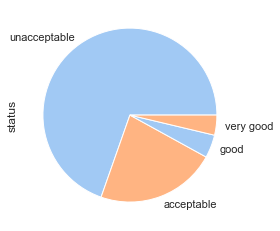

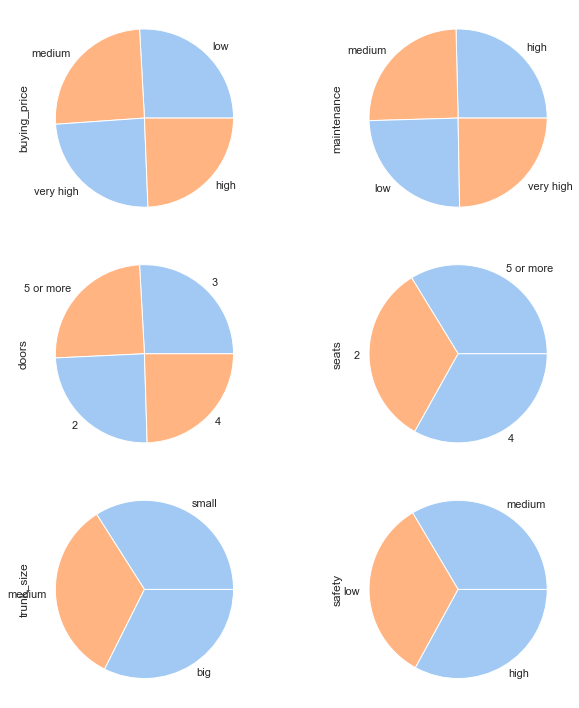

In [4]:
fig, ax = plt.subplots()
df['status'].value_counts().plot(kind='pie',y='status',ax=ax, colors=colors)
fig1, axs1s = plt.subplots(3,2,figsize=(10,10))
axs1 = [sub for x in axs1s for sub in x]
df['buying_price'].value_counts().plot(kind='pie',y='buying_price',ax=axs1[0], colors=colors)
df['maintenance'].value_counts().plot(kind='pie',y='maintenance',ax=axs1[1], colors=colors)
df['doors'].value_counts().plot(kind='pie',y='doors',ax=axs1[2], colors=colors)
df['seats'].value_counts().plot(kind='pie',y='seats',ax=axs1[3], colors=colors)
df['trunk_size'].value_counts().plot(kind='pie',y='trunk_size',ax=axs1[4], colors=colors)
df['safety'].value_counts().plot(kind='pie',y='safety',ax=axs1[5], colors=colors)
plt.tight_layout()

### Međusobne zavisnosti prediktora i ciljne promenljive

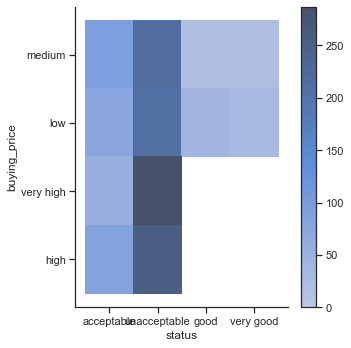

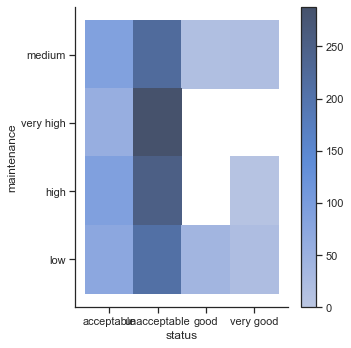

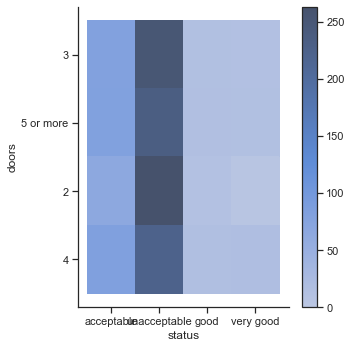

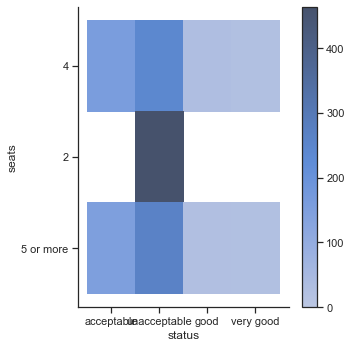

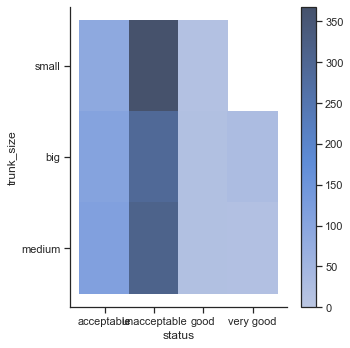

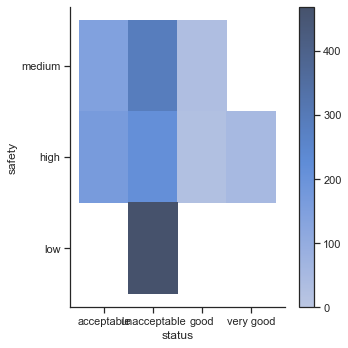

In [5]:
sns.displot(df, x="status", y="buying_price", cbar=True)
sns.displot(df, x="status", y="maintenance", cbar=True)
sns.displot(df, x="status", y="doors", cbar=True)
sns.displot(df, x="status", y="seats", cbar=True)
sns.displot(df, x="status", y="trunk_size", cbar=True)
sns.displot(df, x="status", y="safety", cbar=True)
plt.tight_layout()

### Kodiranje kategoričkih promenljivih

In [6]:
df['buying_price'].replace(['low', 'medium', 'high','very high'],
                        [0, 1, 2, 3], inplace=True)
df['maintenance'].replace(['low', 'medium', 'high','very high'],
                        [0, 1, 2, 3], inplace=True)
df['doors'].replace(['2', '3', '4','5 or more'],
                        [0, 1, 2, 3], inplace=True)
df['seats'].replace(['2', '4', '5 or more'],
                        [0, 1, 2], inplace=True)
df['trunk_size'].replace(['small', 'medium', 'big'],
                        [0, 1, 2], inplace=True)
df['safety'].replace(['low', 'medium', 'high'],
                        [0, 1, 2], inplace=True)
df['status'].replace(['unacceptable', 'acceptable', 'good','very good'],
                        [0, 1, 2,3], inplace=True)
df=df[['buying_price', 'maintenance', 'doors', 'seats', 'trunk_size', 'safety','status']].apply(pd.to_numeric)

### Podela na obučavajući i testirajući skup i izbor broja suseda

In [7]:
X=df.iloc[:,:-1].values
y=df.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Funkcija za proračun Menhetn distance između primera, i predikciju na osnovu većine

In [8]:
def dist(X1,X2):
    return np.sum(np.abs(X1-X2))
def y_predict(X_train, y_train, X_test, k):
    y_pred=[None]*np.shape(X_test)[0]
    for j in range(np.shape(X_test)[0]):
        d=np.zeros(np.shape(y_train))
        for i in range(np.shape(X_train)[0]):
            d[i]=dist(X_train[i,:],X_test[j,:])
        list1, y_sorted = zip(*sorted(zip(d, y_train)))
        y_pred[j]=mode(y_sorted[:k])
    return y_pred

### Određivanje optimalne vrednosti parametra k

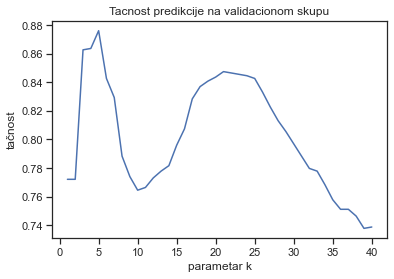

In [9]:
kf = KFold(n_splits=5)
kf.get_n_splits(X_train)
K=np.linspace(1,40,40, dtype=int)
acc=np.zeros((len(K),5))

for k in K:
    i=0
    for train_index, test_index in kf.split(X_train):
        X_train_new, X_val = X[train_index], X[test_index]
        y_train_new, y_val = y[train_index], y[test_index]
        acc[k-1,i]=accuracy_score(y_val,y_predict(X_train_new,y_train_new,X_val,k))
        i+=1
acc=np.mean(acc,axis=1)
fig3,ax3= plt.subplots()
ax3.plot(K,acc)
ax3.set_xlabel('parametar k')
ax3.set_ylabel('tačnost')
ax3.set_title('Tacnost predikcije na validacionom skupu')
plt.show()

In [10]:
k=K[np.argmax(acc)]
print(k)

5


### Rezultati algoritma na testirajućem skupu

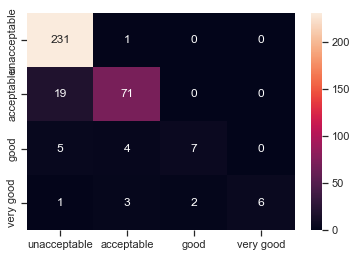

In [11]:
M = confusion_matrix(y_test, y_predict(X_train, y_train, X_test, k))
ax = sns.heatmap(M,annot=True, fmt="d")
ax.set_yticklabels(['unacceptable', 'acceptable', 'good','very good'])
ax.set_xticklabels(['unacceptable', 'acceptable', 'good','very good'])
plt.show()

### KNN korišćenjem ugrađenog modela iz biblioteke scikit-learn

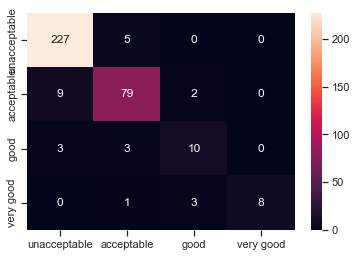

In [12]:
neigh = KNeighborsClassifier(n_neighbors=k)
neigh.fit(X_train, y_train)
y_pred=neigh.predict(X_test)
M=confusion_matrix(y_test, y_pred)
ax=sns.heatmap(M,annot=True, fmt="d")
ax.set_yticklabels(['unacceptable', 'acceptable', 'good','very good'])
ax.set_xticklabels(['unacceptable', 'acceptable', 'good','very good'])
plt.show()